In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

# Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ModelX/Dementia Prediction Dataset.csv')

/tmp/ipython-input-1330818034.py:1: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ModelX/Dementia Prediction Dataset.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195196 entries, 0 to 195195
Columns: 1024 entries, NACCID to NPATGFR4
dtypes: float64(135), int64(747), object(142)
memory usage: 1.5+ GB


In [6]:
df.isna().sum()

NACCID      0
NACCADC     0
PACKET      0
FORMVER     0
VISITMO     0
           ..
NPATGFRN    0
NPATGFR1    0
NPATGFR2    0
NPATGFR3    0
NPATGFR4    0
Length: 1024, dtype: int64

In [7]:
demographic_features = [
    'NACCID', 'NACCADC', 'SEX', 'NACCAGE', 'NACCAGEB',
    'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX',
    'RACESEC', 'RACESECX', 'RACETER', 'RACETERX', 'NACCNIHR',
    'PRIMLANG', 'PRIMLANX', 'EDUC', 'MARISTAT', 'NACCLIVS',
    'INDEPEND', 'RESIDENC', 'HANDED'
]

administrative_features = [
    'PACKET', 'FORMVER', 'VISITMO', 'VISITDAY', 'VISITYR',
    'NACCVNUM', 'NACCAVST', 'NACCNVST', 'NACCDAYS', 'NACCFDYS',
    'NACCACTV', 'NACCNOVS', 'NACCDSMO', 'NACCDSDY', 'NACCDSYR',
    'NACCNURP', 'NACCNRMO', 'NACCNRDY', 'NACCNRYR', 'NACCPAFF',
    'TELCOV', 'TELMOD', 'MODCOMM'
]

coparticipant_features = [
    'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR',
    'INHISPOX', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX',
    'INRATER', 'INRATERX', 'INEDUC', 'INRELTO', 'INRELTOX',
    'INKNOWN', 'INLIWYTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCNINR'
]

family_history_features = [
    'NACCFAM', 'NACCMOM', 'NACCDAD'
]

language_features = [
    'NACCSPNL', 'NACCENGL', 'APREFLAN', 'AYRSPAN', 'AYRENGL',
    'APCSPAN', 'APCENGL', 'ASPKSPAN', 'AREASPAN', 'AWRISPAN',
    'AUNDSPAN', 'ASPKENGL', 'AREAENGL', 'AWRIENGL', 'AUNDENGL'
]

data_availability_features = [
    'NACCFTD', 'NACCLBDM', 'NACCNMRI', 'NACCMRSA', 'NACCNAPA',
    'NACCAPSA', 'NACCACSF', 'NACCPCSF', 'NACCTCSF', 'NACCAUTP'
]

primary_targets = [
    'NACCUDSD',
    'DEMENTED',
    'NORMCOG',
    'NACCTMCI',
    'IMPNOMCI'
]

diagnosis_targets = [
    'NACCALZD',
    'NACCLBDE',
    'NACCBVFT',
    'NACCPPA',
    'CVD',
    'PARK',
    'PSP',
    'CORT',
    'DEP',
    'ALCDEM'
]

syndrome_targets = [
    'AMNDEM',
    'PCA',
    'NACCPPAG',
    'NACCLBDS',
    'NAMNDEM'
]

# All non-medical features combined
all_non_medical_features = (demographic_features + administrative_features +
                           coparticipant_features + family_history_features +
                           language_features + data_availability_features)

# Main targets
main_targets = primary_targets + ['NACCALZD']  # Add Alzheimer's as key target

In [8]:
import pandas as pd
import numpy as np

def simple_data_cleaning(df):
    """
    Simple data cleaning: mode for categorical, mean/median for numerical
    Returns cleaned dataset ready for use
    """
    print("🧹 SIMPLE DATA CLEANING")
    print("=" * 50)

    # Create a copy to avoid modifying original
    df_clean = df.copy()

    # Get all non-medical features that exist in the dataset
    all_non_medical_features = (demographic_features + administrative_features +
                               coparticipant_features + family_history_features +
                               language_features + data_availability_features)

    available_features = [f for f in all_non_medical_features if f in df_clean.columns]

    print(f"Cleaning {len(available_features)} non-medical features...")

    cleaning_log = []

    for feature in available_features:
        missing_before = df_clean[feature].isnull().sum()

        if missing_before > 0:
            # Check if feature is categorical or numerical
            if df_clean[feature].dtype == 'object' or df_clean[feature].nunique() < 20:
                # Categorical - use mode
                mode_value = df_clean[feature].mode()
                if len(mode_value) > 0:
                    df_clean[feature].fillna(mode_value[0], inplace=True)
                    cleaning_log.append(f"{feature}: {missing_before} missing → mode '{mode_value[0]}'")
                else:
                    # If no mode (all missing), use 'Unknown'
                    df_clean[feature].fillna('Unknown', inplace=True)
                    cleaning_log.append(f"{feature}: {missing_before} missing → 'Unknown'")
            else:
                # Numerical - use median (robust to outliers)
                median_value = df_clean[feature].median()
                if not pd.isna(median_value):
                    df_clean[feature].fillna(median_value, inplace=True)
                    cleaning_log.append(f"{feature}: {missing_before} missing → median {median_value:.2f}")
                else:
                    # If median is NaN (all missing), use 0
                    df_clean[feature].fillna(0, inplace=True)
                    cleaning_log.append(f"{feature}: {missing_before} missing → 0")

    # Print cleaning summary
    print("\n📋 CLEANING SUMMARY:")
    for log in cleaning_log[:10]:  # Show first 10
        print(f"   {log}")
    if len(cleaning_log) > 10:
        print(f"   ... and {len(cleaning_log) - 10} more features cleaned")

    # Final stats
    total_missing_after = df_clean[available_features].isnull().sum().sum()
    print(f"\n✅ CLEANING COMPLETE!")
    print(f"   Total missing values remaining: {total_missing_after}")
    print(f"   Dataset shape: {df_clean[available_features].shape}")

    return df_clean[available_features]

# Run the simple cleaning
cleaned_df = simple_data_cleaning(df)

print("\n🎉 YOUR CLEANED DATASET IS READY!")
print("Variable name: 'cleaned_df'")
print(f"Shape: {cleaned_df.shape}")
print(f"Columns: {len(cleaned_df.columns)}")
print(f"Missing values: {cleaned_df.isnull().sum().sum()}")

# Show a sample of the cleaned data
print("\n👀 SAMPLE OF CLEANED DATA (first 5 rows, first 8 columns):")
print(cleaned_df.iloc[:5, :8].to_string())

🧹 SIMPLE DATA CLEANING
Cleaning 80 non-medical features...

📋 CLEANING SUMMARY:
   HISPORX: 194669 missing → mode 'Spain'
   RACEX: 192851 missing → mode 'HISPANIC'
   RACESECX: 194813 missing → mode 'Jewish'
   RACETERX: 195160 missing → mode 'Irish'
   PRIMLANX: 192464 missing → mode 'German'
   INHISPOX: 194958 missing → mode 'Spain'
   INRACEX: 193608 missing → mode 'HISPANIC'
   INRASECX: 194899 missing → mode 'Jewish'
   INRATERX: 195137 missing → mode 'Irish'
   INRELTOX: 193644 missing → mode 'self'


/tmp/ipython-input-3881879847.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[feature].fillna(mode_value[0], inplace=True)



✅ CLEANING COMPLETE!
   Total missing values remaining: 0
   Dataset shape: (195196, 80)

🎉 YOUR CLEANED DATASET IS READY!
Variable name: 'cleaned_df'
Shape: (195196, 80)
Columns: 80
Missing values: 0

👀 SAMPLE OF CLEANED DATA (first 5 rows, first 8 columns):
       NACCID  NACCADC  SEX  NACCAGE  NACCAGEB  HISPANIC  HISPOR HISPORX
0  NACC002909      186    1       70        70         0      88   Spain
1  NACC002909      186    1       71        70         0      88   Spain
2  NACC003487      186    1       66        66         0      88   Spain
3  NACC004352      186    2       63        63         1       1   Spain
4  NACC004687      186    1       77        77         1       1   Spain


In [9]:
# Total rows
len(cleaned_df)

195196

In [10]:
# Number of columns
len(df.columns)

1024

In [11]:
def comprehensive_eda(df, features, category_name):
    """
    Run comprehensive EDA for a set of features
    """
    print(f"📊 {'='*60}")
    print(f"📊 EDA FOR: {category_name}")
    print(f"📊 {'='*60}")

    # Filter only existing features in the dataset
    available_features = [f for f in features if f in df.columns]
    print(f"📈 Available features: {len(available_features)}/{len(features)}")

    if not available_features:
        print("❌ No features available in this dataset")
        return

    # Create subplots
    n_features = len(available_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]

    for i, feature in enumerate(available_features):
        if i >= len(axes):
            break

        ax = axes[i]

        # Check data type and create appropriate plot
        if df[feature].dtype in ['object', 'category'] or df[feature].nunique() < 20:
            # Categorical feature
            value_counts = df[feature].value_counts().head(10)  # Top 10 categories
            if len(value_counts) > 0:
                bars = ax.bar(range(len(value_counts)), value_counts.values)
                ax.set_title(f'{feature}\n(Unique: {df[feature].nunique()})', fontsize=10)
                ax.set_xticks(range(len(value_counts)))
                ax.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=8)

                # Add value labels on bars
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{int(height)}', ha='center', va='bottom', fontsize=8)
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

        else:
            # Numerical feature
            if df[feature].notna().sum() > 0:
                ax.hist(df[feature].dropna(), bins=30, alpha=0.7, edgecolor='black')
                ax.set_title(f'{feature}\n(Mean: {df[feature].mean():.2f})', fontsize=10)
                ax.set_xlabel('Value')
                ax.set_ylabel('Frequency')
            else:
                ax.text(0.5, 0.5, 'No numerical data', ha='center', va='center', transform=ax.transAxes)

    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print(f"\n📋 DETAILED STATISTICS FOR {category_name}:")
    print("-" * 50)

    for feature in available_features:
        print(f"\n🔍 {feature}:")
        print(f"   Data type: {df[feature].dtype}")
        print(f"   Missing values: {df[feature].isnull().sum()} ({df[feature].isnull().mean()*100:.1f}%)")

        if df[feature].dtype in ['object', 'category'] or df[feature].nunique() < 20:
            # Categorical stats
            value_counts = df[feature].value_counts()
            print(f"   Unique values: {df[feature].nunique()}")
            print(f"   Top 5 values:")
            for val, count in value_counts.head().items():
                print(f"     {val}: {count} ({count/len(df)*100:.1f}%)")
        else:
            # Numerical stats
            if df[feature].notna().sum() > 0:
                print(f"   Min: {df[feature].min():.2f}")
                print(f"   Max: {df[feature].max():.2f}")
                print(f"   Mean: {df[feature].mean():.2f}")
                print(f"   Median: {df[feature].median():.2f}")
                print(f"   Std: {df[feature].std():.2f}")

📊 ============================================================
📊 EDA FOR: Demographics
📊 ============================================================
📈 Available features: 23/23


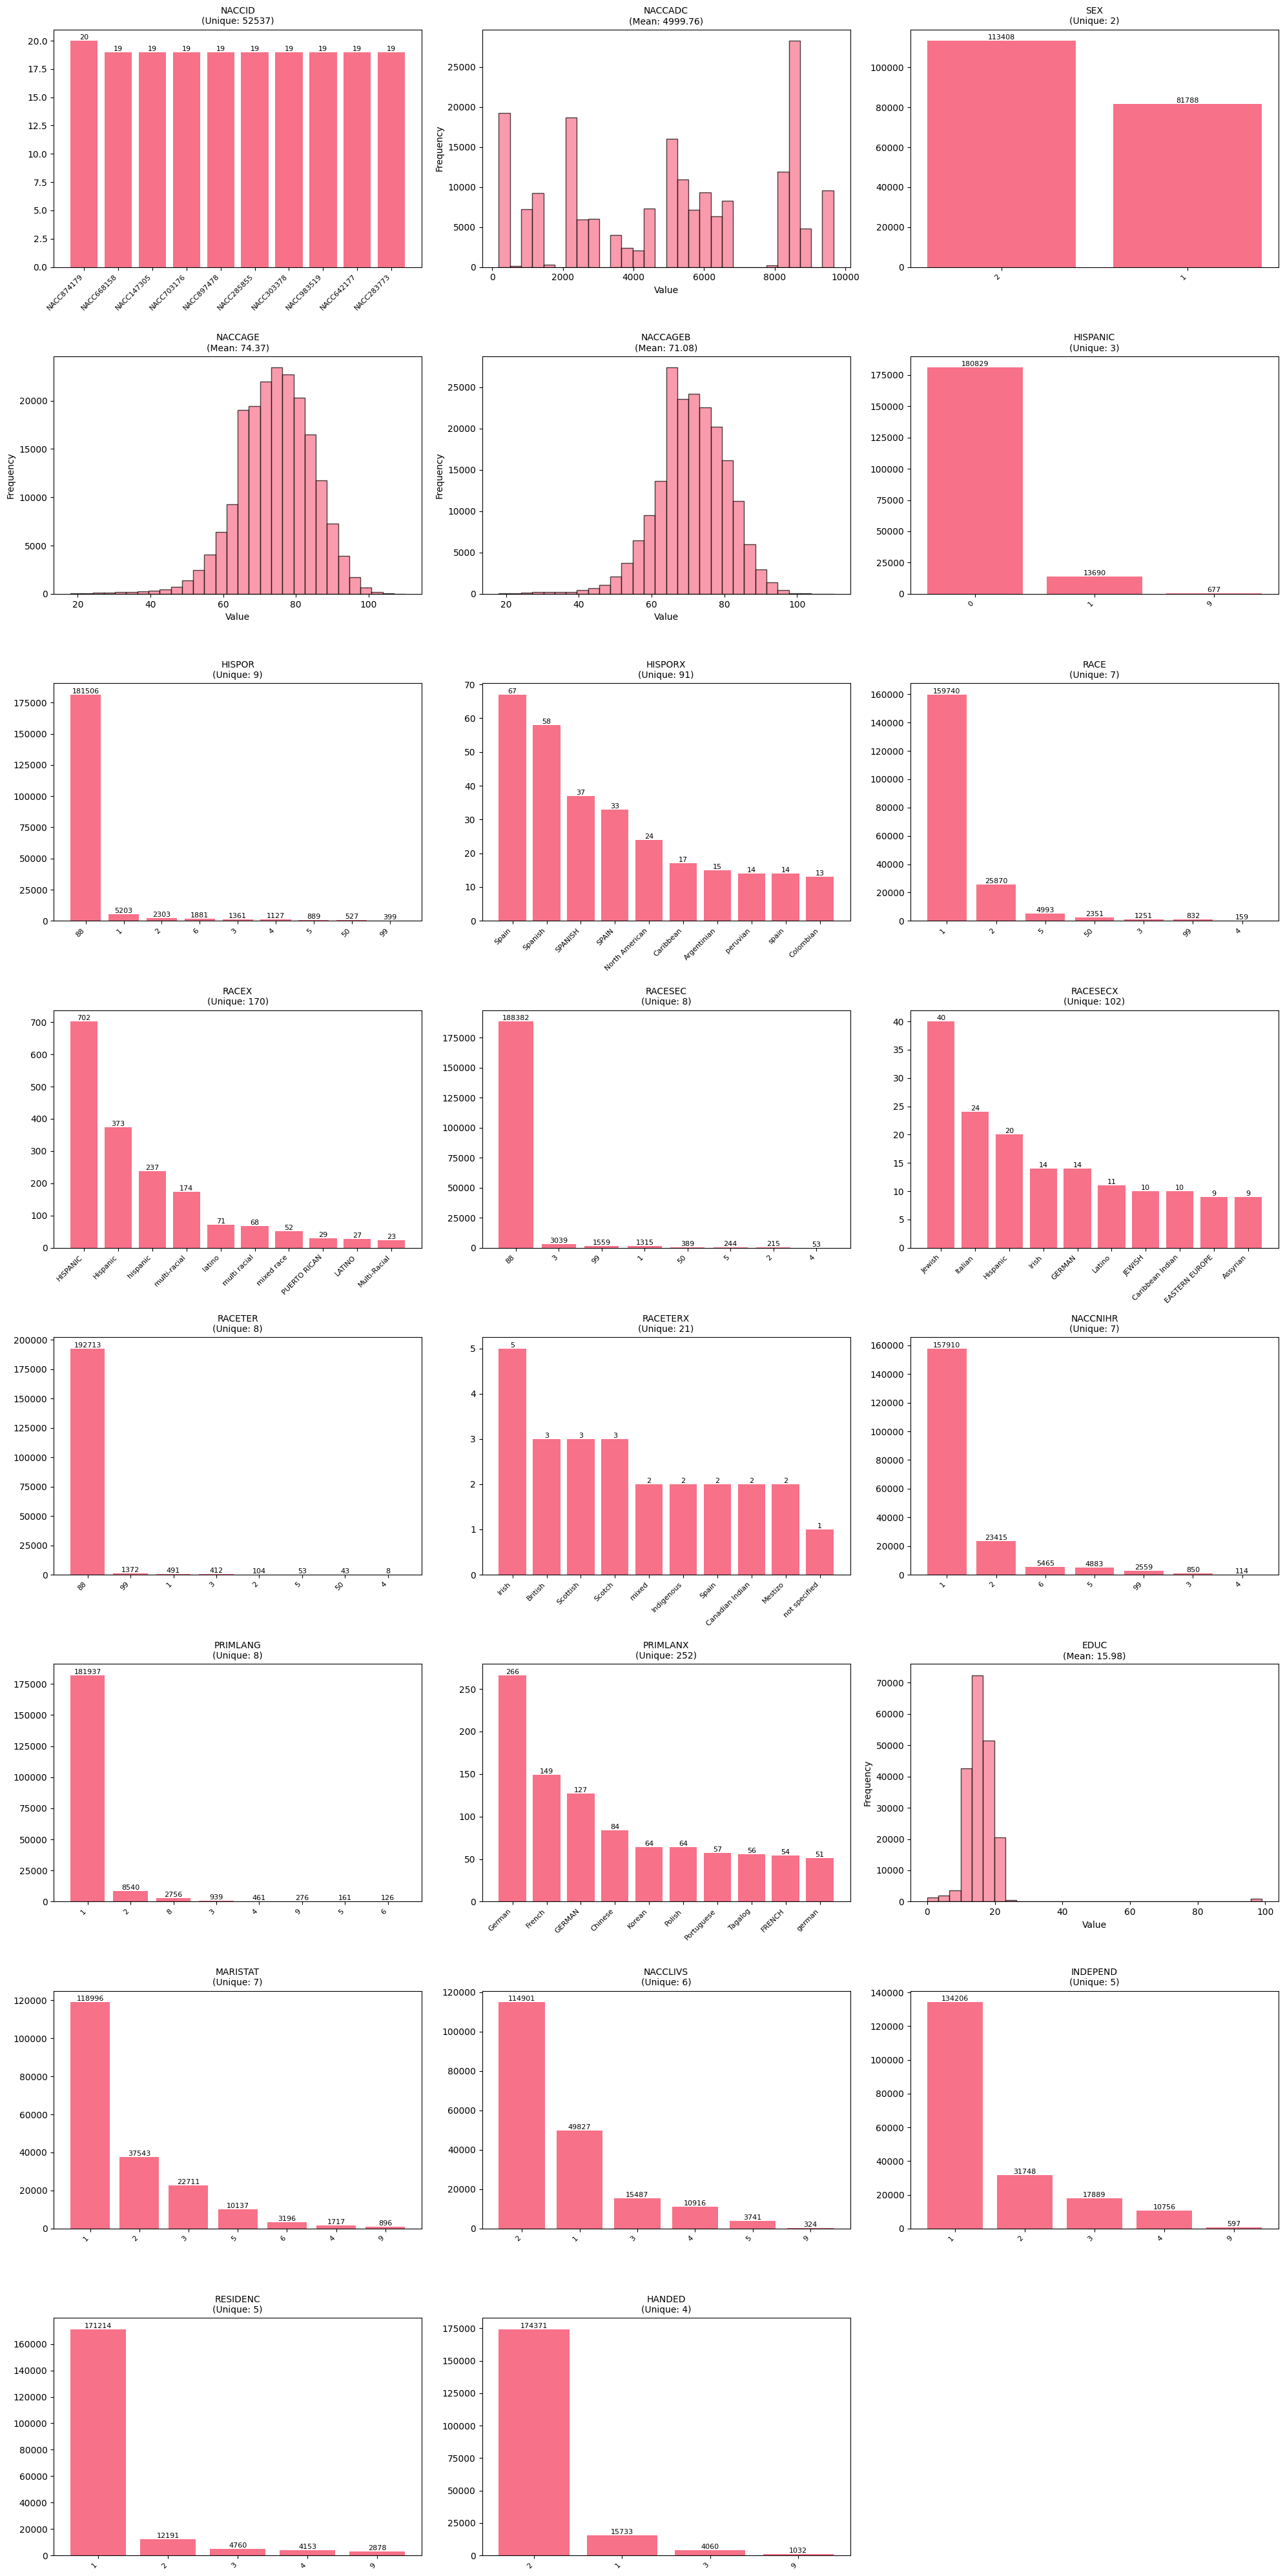


📋 DETAILED STATISTICS FOR Demographics:
--------------------------------------------------

🔍 NACCID:
   Data type: object
   Missing values: 0 (0.0%)
   Unique values: 52537
   Top 5 values:
     NACC874179: 20 (0.0%)
     NACC668158: 19 (0.0%)
     NACC147305: 19 (0.0%)
     NACC703176: 19 (0.0%)
     NACC897478: 19 (0.0%)

🔍 NACCADC:
   Data type: int64
   Missing values: 0 (0.0%)
   Min: 186.00
   Max: 9661.00
   Mean: 4999.76
   Median: 4967.00
   Std: 2980.94

🔍 SEX:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 2
   Top 5 values:
     2: 113408 (58.1%)
     1: 81788 (41.9%)

🔍 NACCAGE:
   Data type: int64
   Missing values: 0 (0.0%)
   Min: 18.00
   Max: 110.00
   Mean: 74.37
   Median: 75.00
   Std: 10.30

🔍 NACCAGEB:
   Data type: int64
   Missing values: 0 (0.0%)
   Min: 18.00
   Max: 110.00
   Mean: 71.08
   Median: 72.00
   Std: 9.87

🔍 HISPANIC:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 3
   Top 5 values:
     0: 180829 (92.6%)


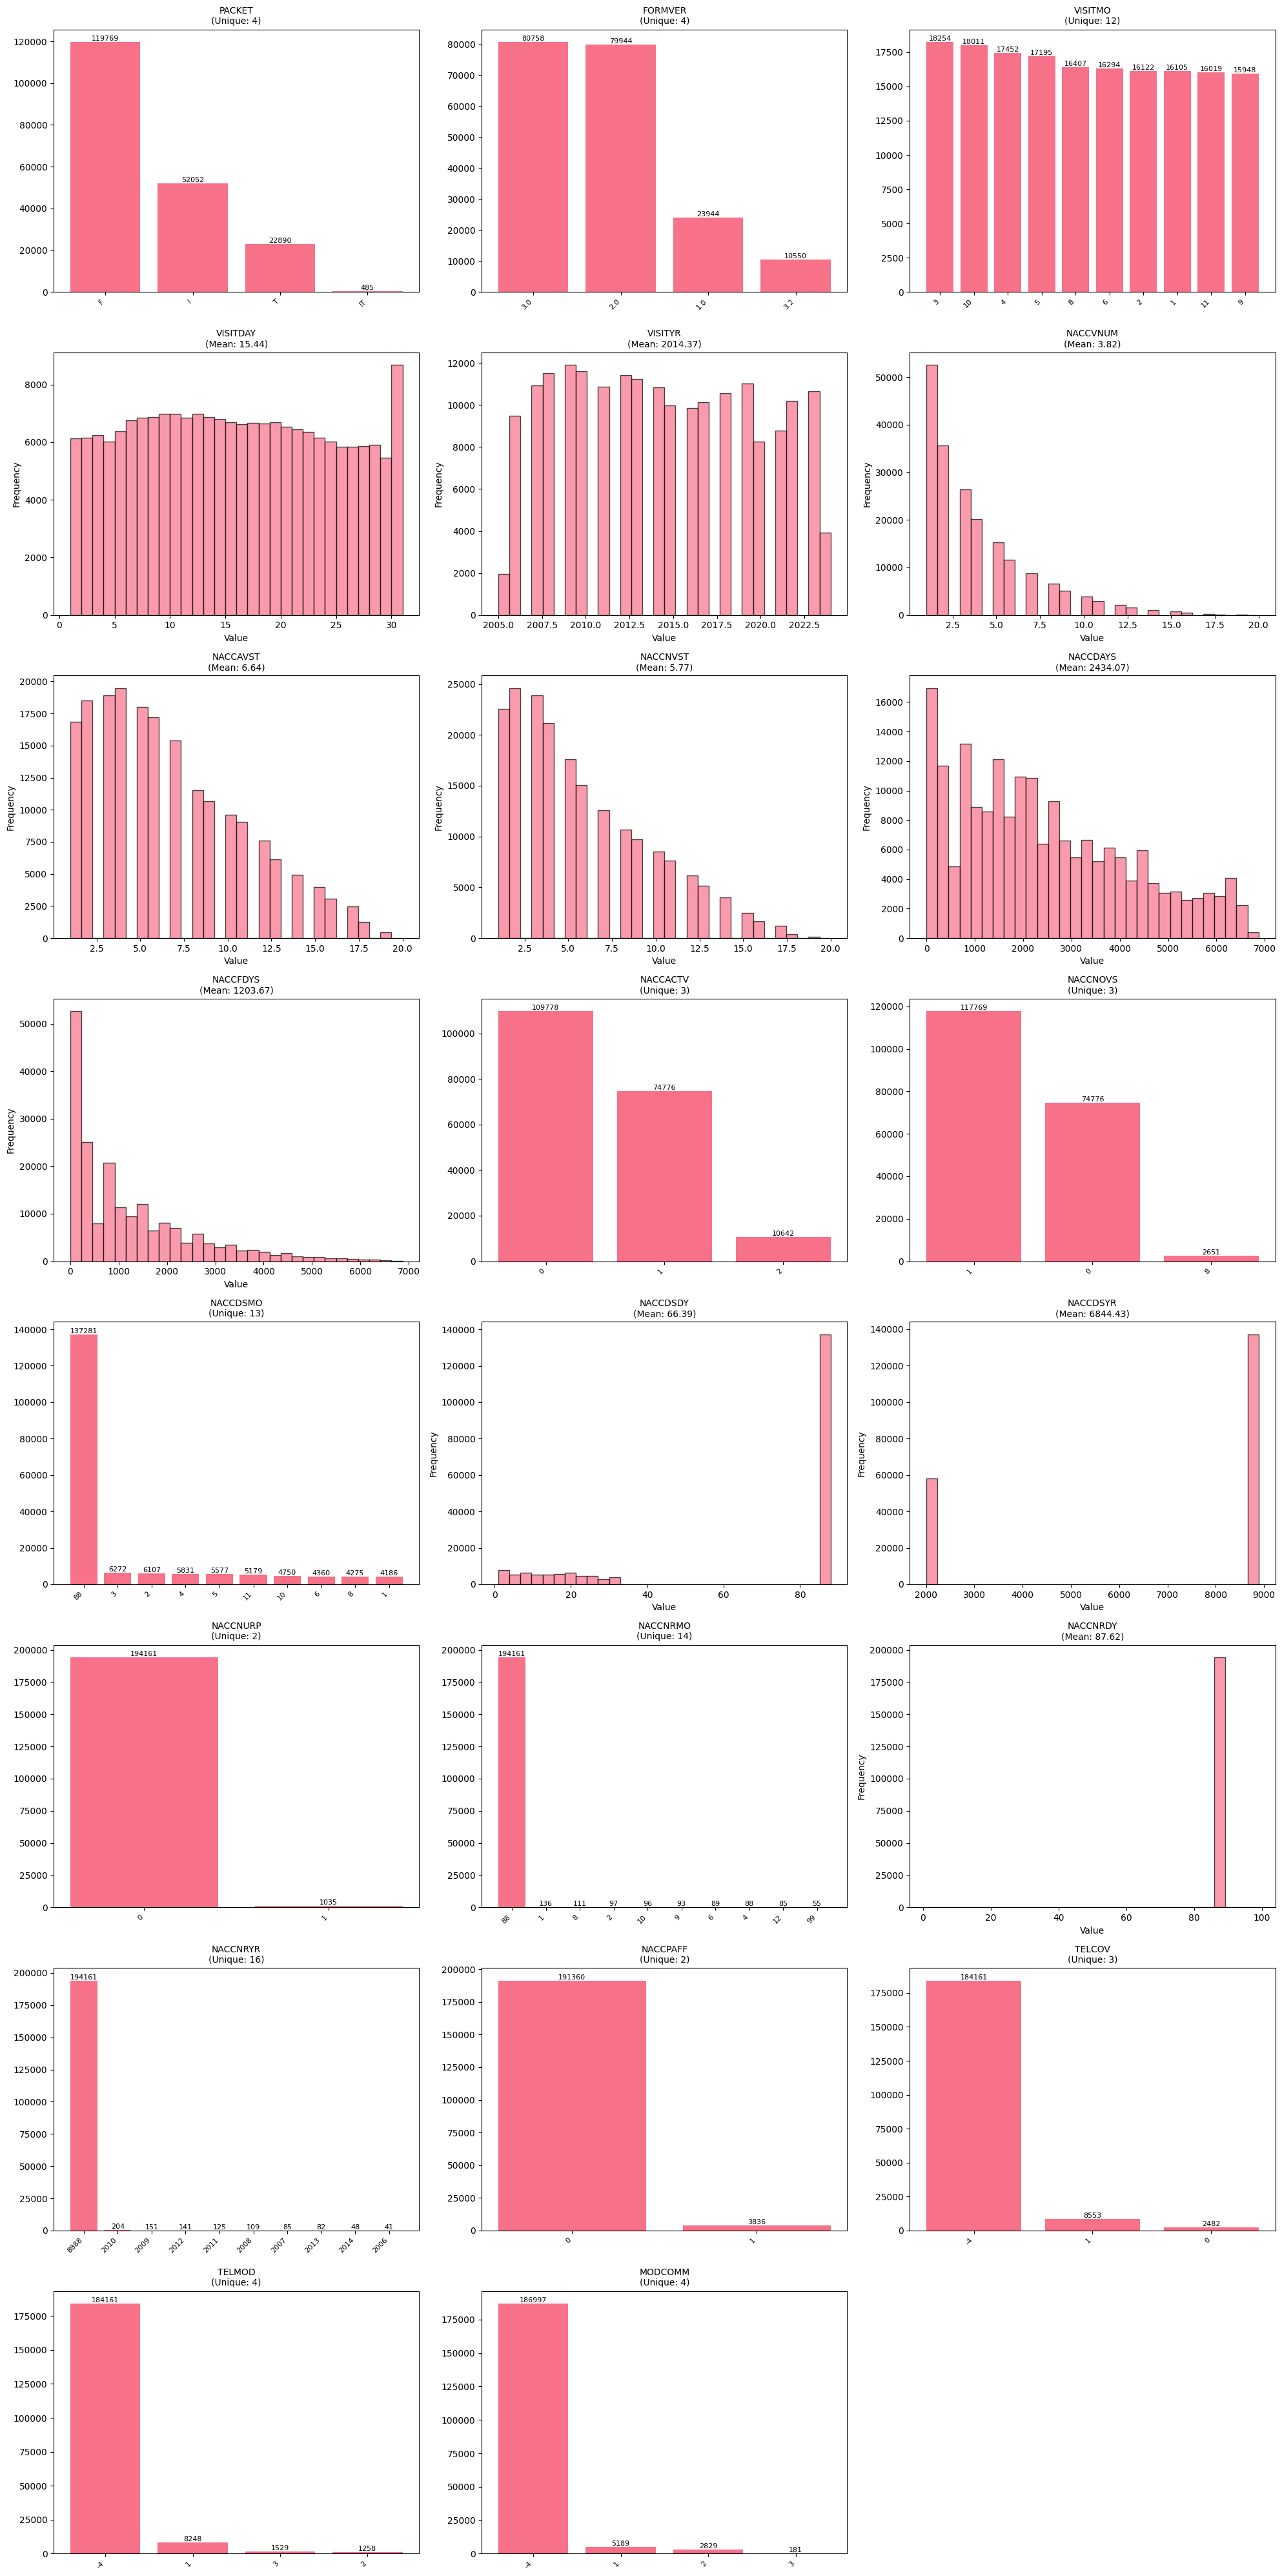


📋 DETAILED STATISTICS FOR Administrative:
--------------------------------------------------

🔍 PACKET:
   Data type: object
   Missing values: 0 (0.0%)
   Unique values: 4
   Top 5 values:
     F: 119769 (61.4%)
     I: 52052 (26.7%)
     T: 22890 (11.7%)
     IT: 485 (0.2%)

🔍 FORMVER:
   Data type: float64
   Missing values: 0 (0.0%)
   Unique values: 4
   Top 5 values:
     3.0: 80758 (41.4%)
     2.0: 79944 (41.0%)
     1.0: 23944 (12.3%)
     3.2: 10550 (5.4%)

🔍 VISITMO:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 12
   Top 5 values:
     3: 18254 (9.4%)
     10: 18011 (9.2%)
     4: 17452 (8.9%)
     5: 17195 (8.8%)
     8: 16407 (8.4%)

🔍 VISITDAY:
   Data type: int64
   Missing values: 0 (0.0%)
   Min: 1.00
   Max: 31.00
   Mean: 15.44
   Median: 15.00
   Std: 8.61

🔍 VISITYR:
   Data type: int64
   Missing values: 0 (0.0%)
   Min: 2005.00
   Max: 2024.00
   Mean: 2014.37
   Median: 2014.00
   Std: 5.33

🔍 NACCVNUM:
   Data type: int64
   Missing values

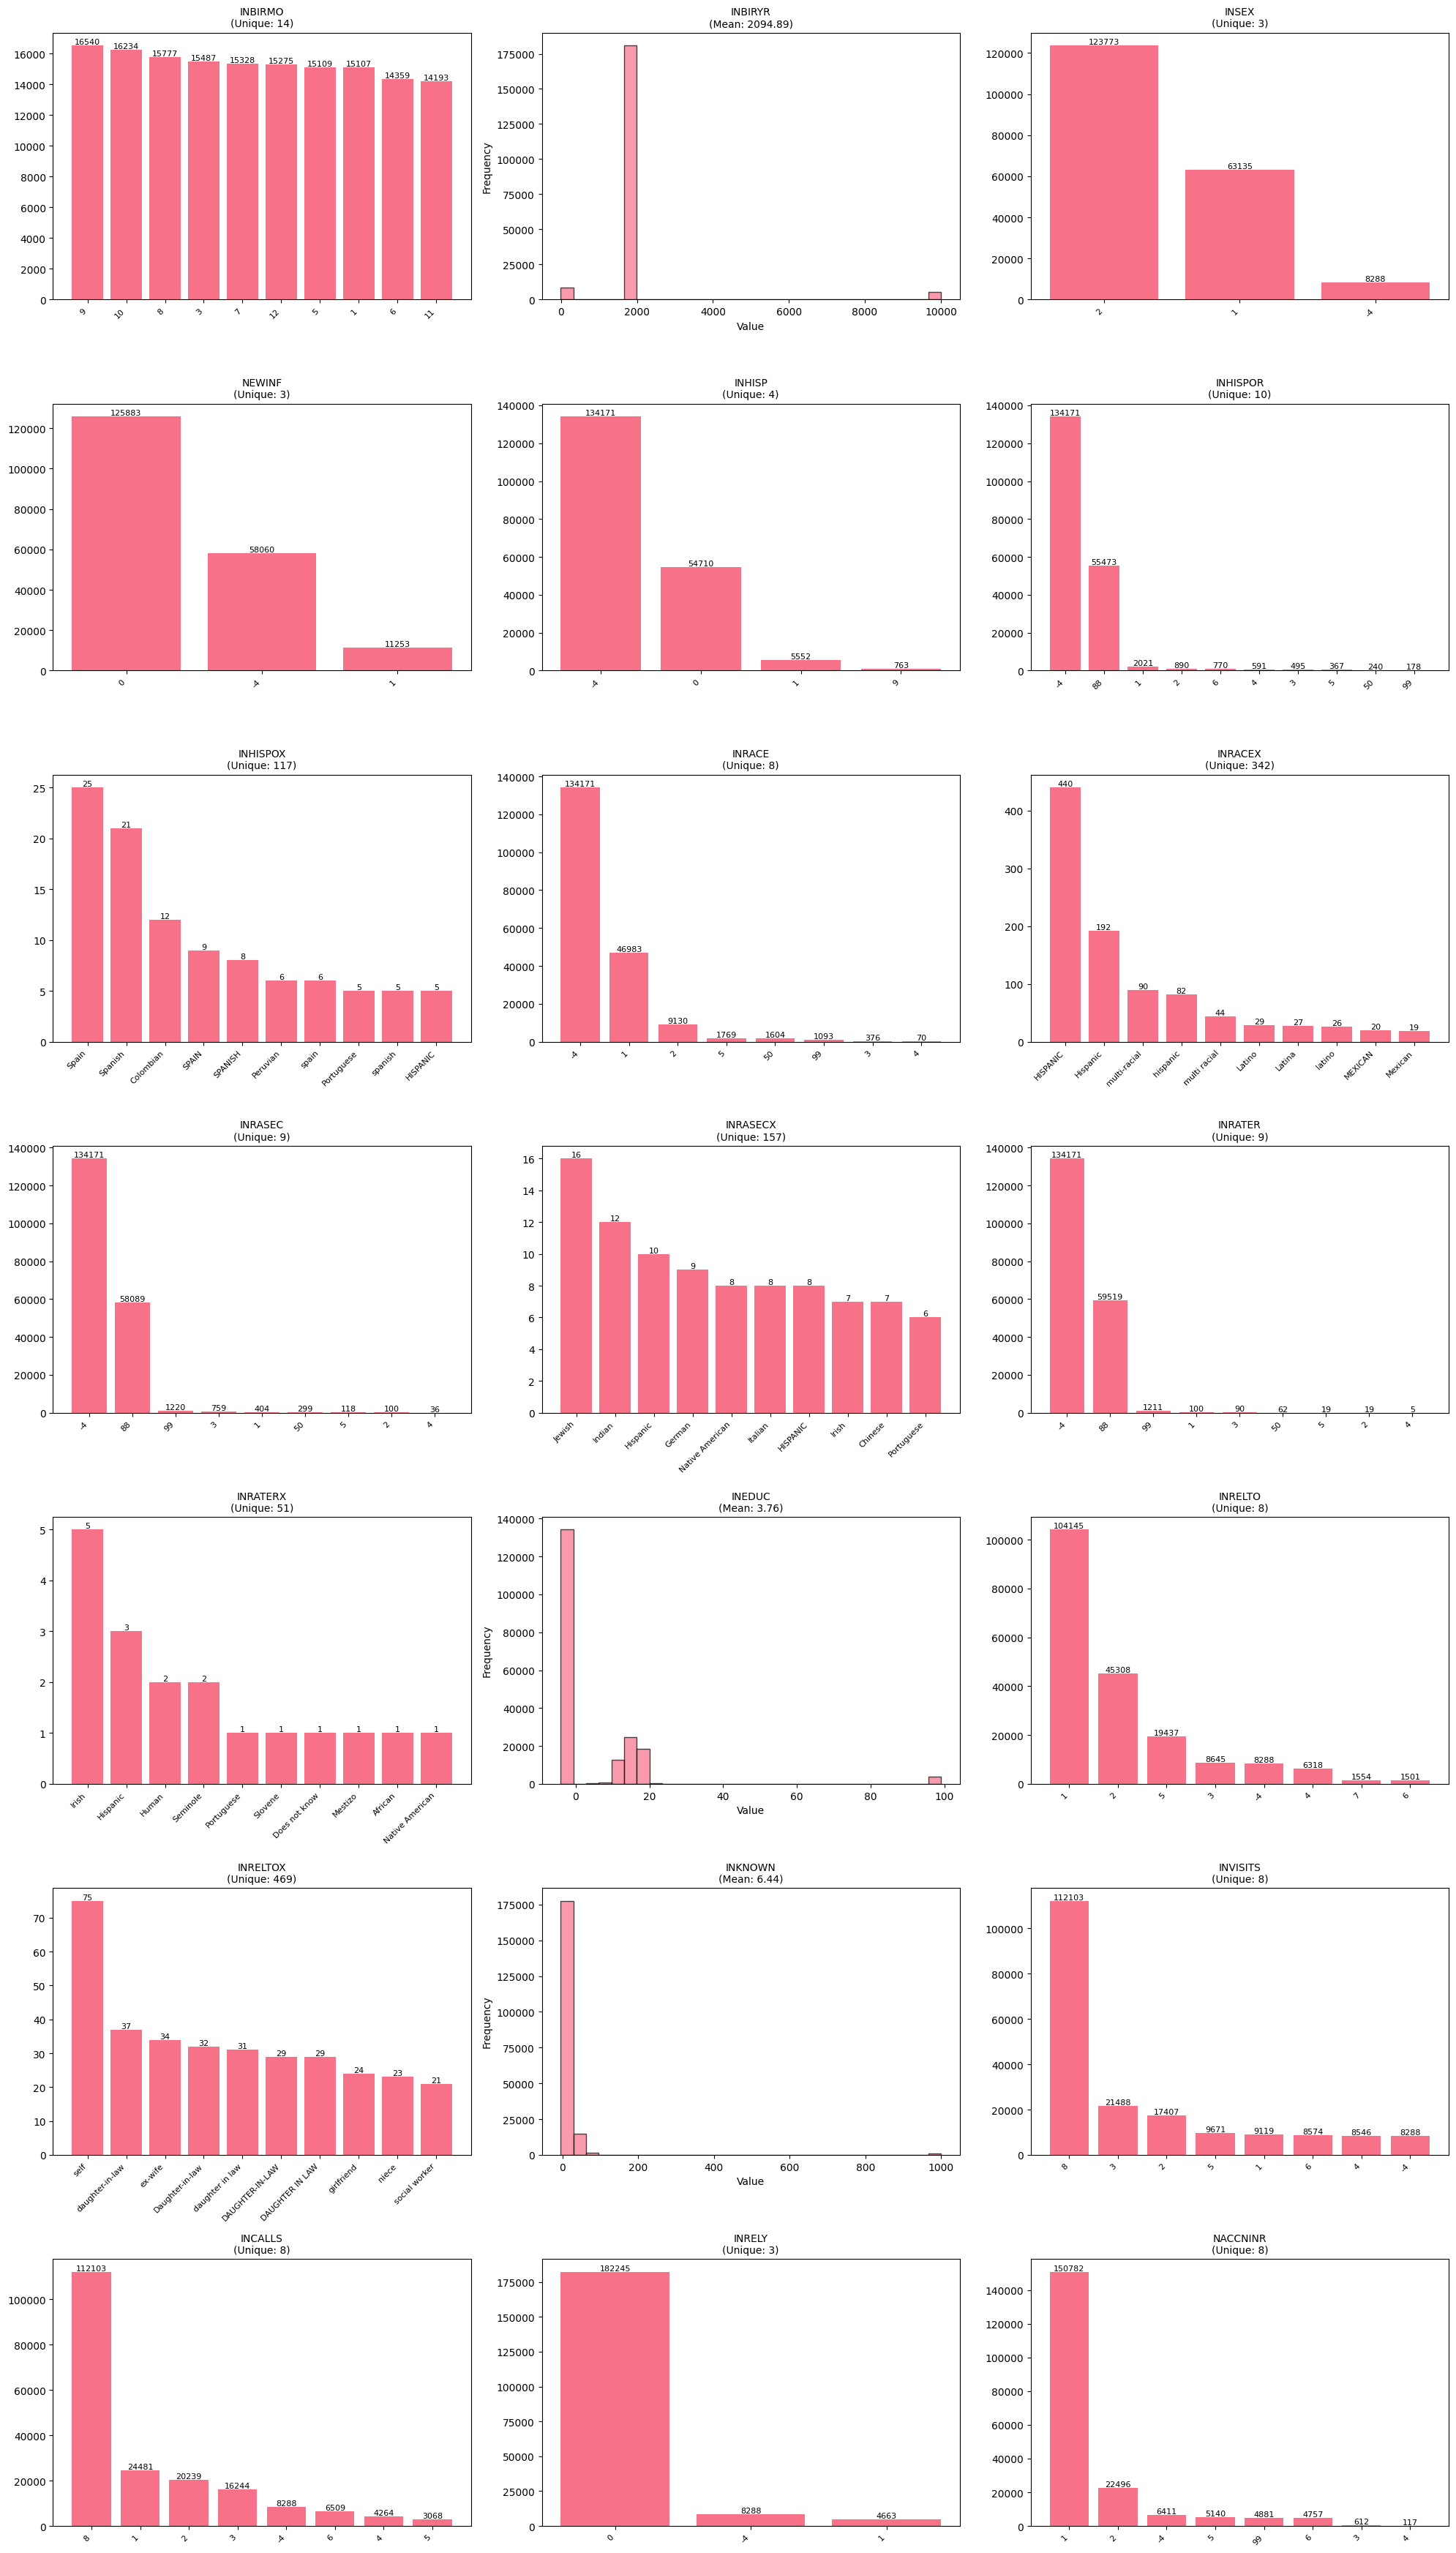


📋 DETAILED STATISTICS FOR Co-participant:
--------------------------------------------------

🔍 INBIRMO:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 14
   Top 5 values:
     9: 16540 (8.5%)
     10: 16234 (8.3%)
     8: 15777 (8.1%)
     3: 15487 (7.9%)
     7: 15328 (7.9%)

🔍 INBIRYR:
   Data type: int64
   Missing values: 0 (0.0%)
   Min: -4.00
   Max: 9999.00
   Mean: 2094.89
   Median: 1948.00
   Std: 1407.98

🔍 INSEX:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 3
   Top 5 values:
     2: 123773 (63.4%)
     1: 63135 (32.3%)
     -4: 8288 (4.2%)

🔍 NEWINF:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 3
   Top 5 values:
     0: 125883 (64.5%)
     -4: 58060 (29.7%)
     1: 11253 (5.8%)

🔍 INHISP:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 4
   Top 5 values:
     -4: 134171 (68.7%)
     0: 54710 (28.0%)
     1: 5552 (2.8%)
     9: 763 (0.4%)

🔍 INHISPOR:
   Data type: int64
   Missing values: 0 (

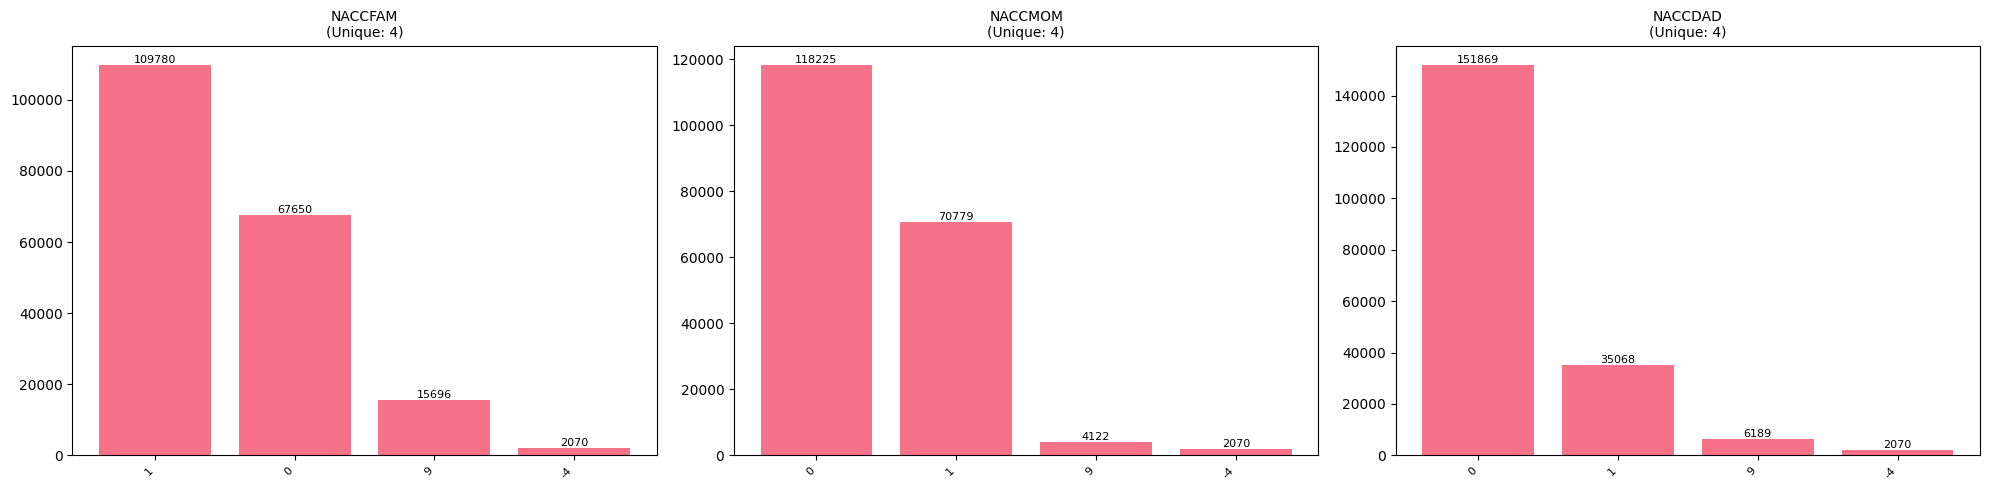


📋 DETAILED STATISTICS FOR Family History:
--------------------------------------------------

🔍 NACCFAM:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 4
   Top 5 values:
     1: 109780 (56.2%)
     0: 67650 (34.7%)
     9: 15696 (8.0%)
     -4: 2070 (1.1%)

🔍 NACCMOM:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 4
   Top 5 values:
     0: 118225 (60.6%)
     1: 70779 (36.3%)
     9: 4122 (2.1%)
     -4: 2070 (1.1%)

🔍 NACCDAD:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 4
   Top 5 values:
     0: 151869 (77.8%)
     1: 35068 (18.0%)
     9: 6189 (3.2%)
     -4: 2070 (1.1%)
📊 ============================================================
📊 EDA FOR: Language
📊 ============================================================
📈 Available features: 0/15
❌ No features available in this dataset
📊 ============================================================
📊 EDA FOR: Data Availability
📊 =================================================

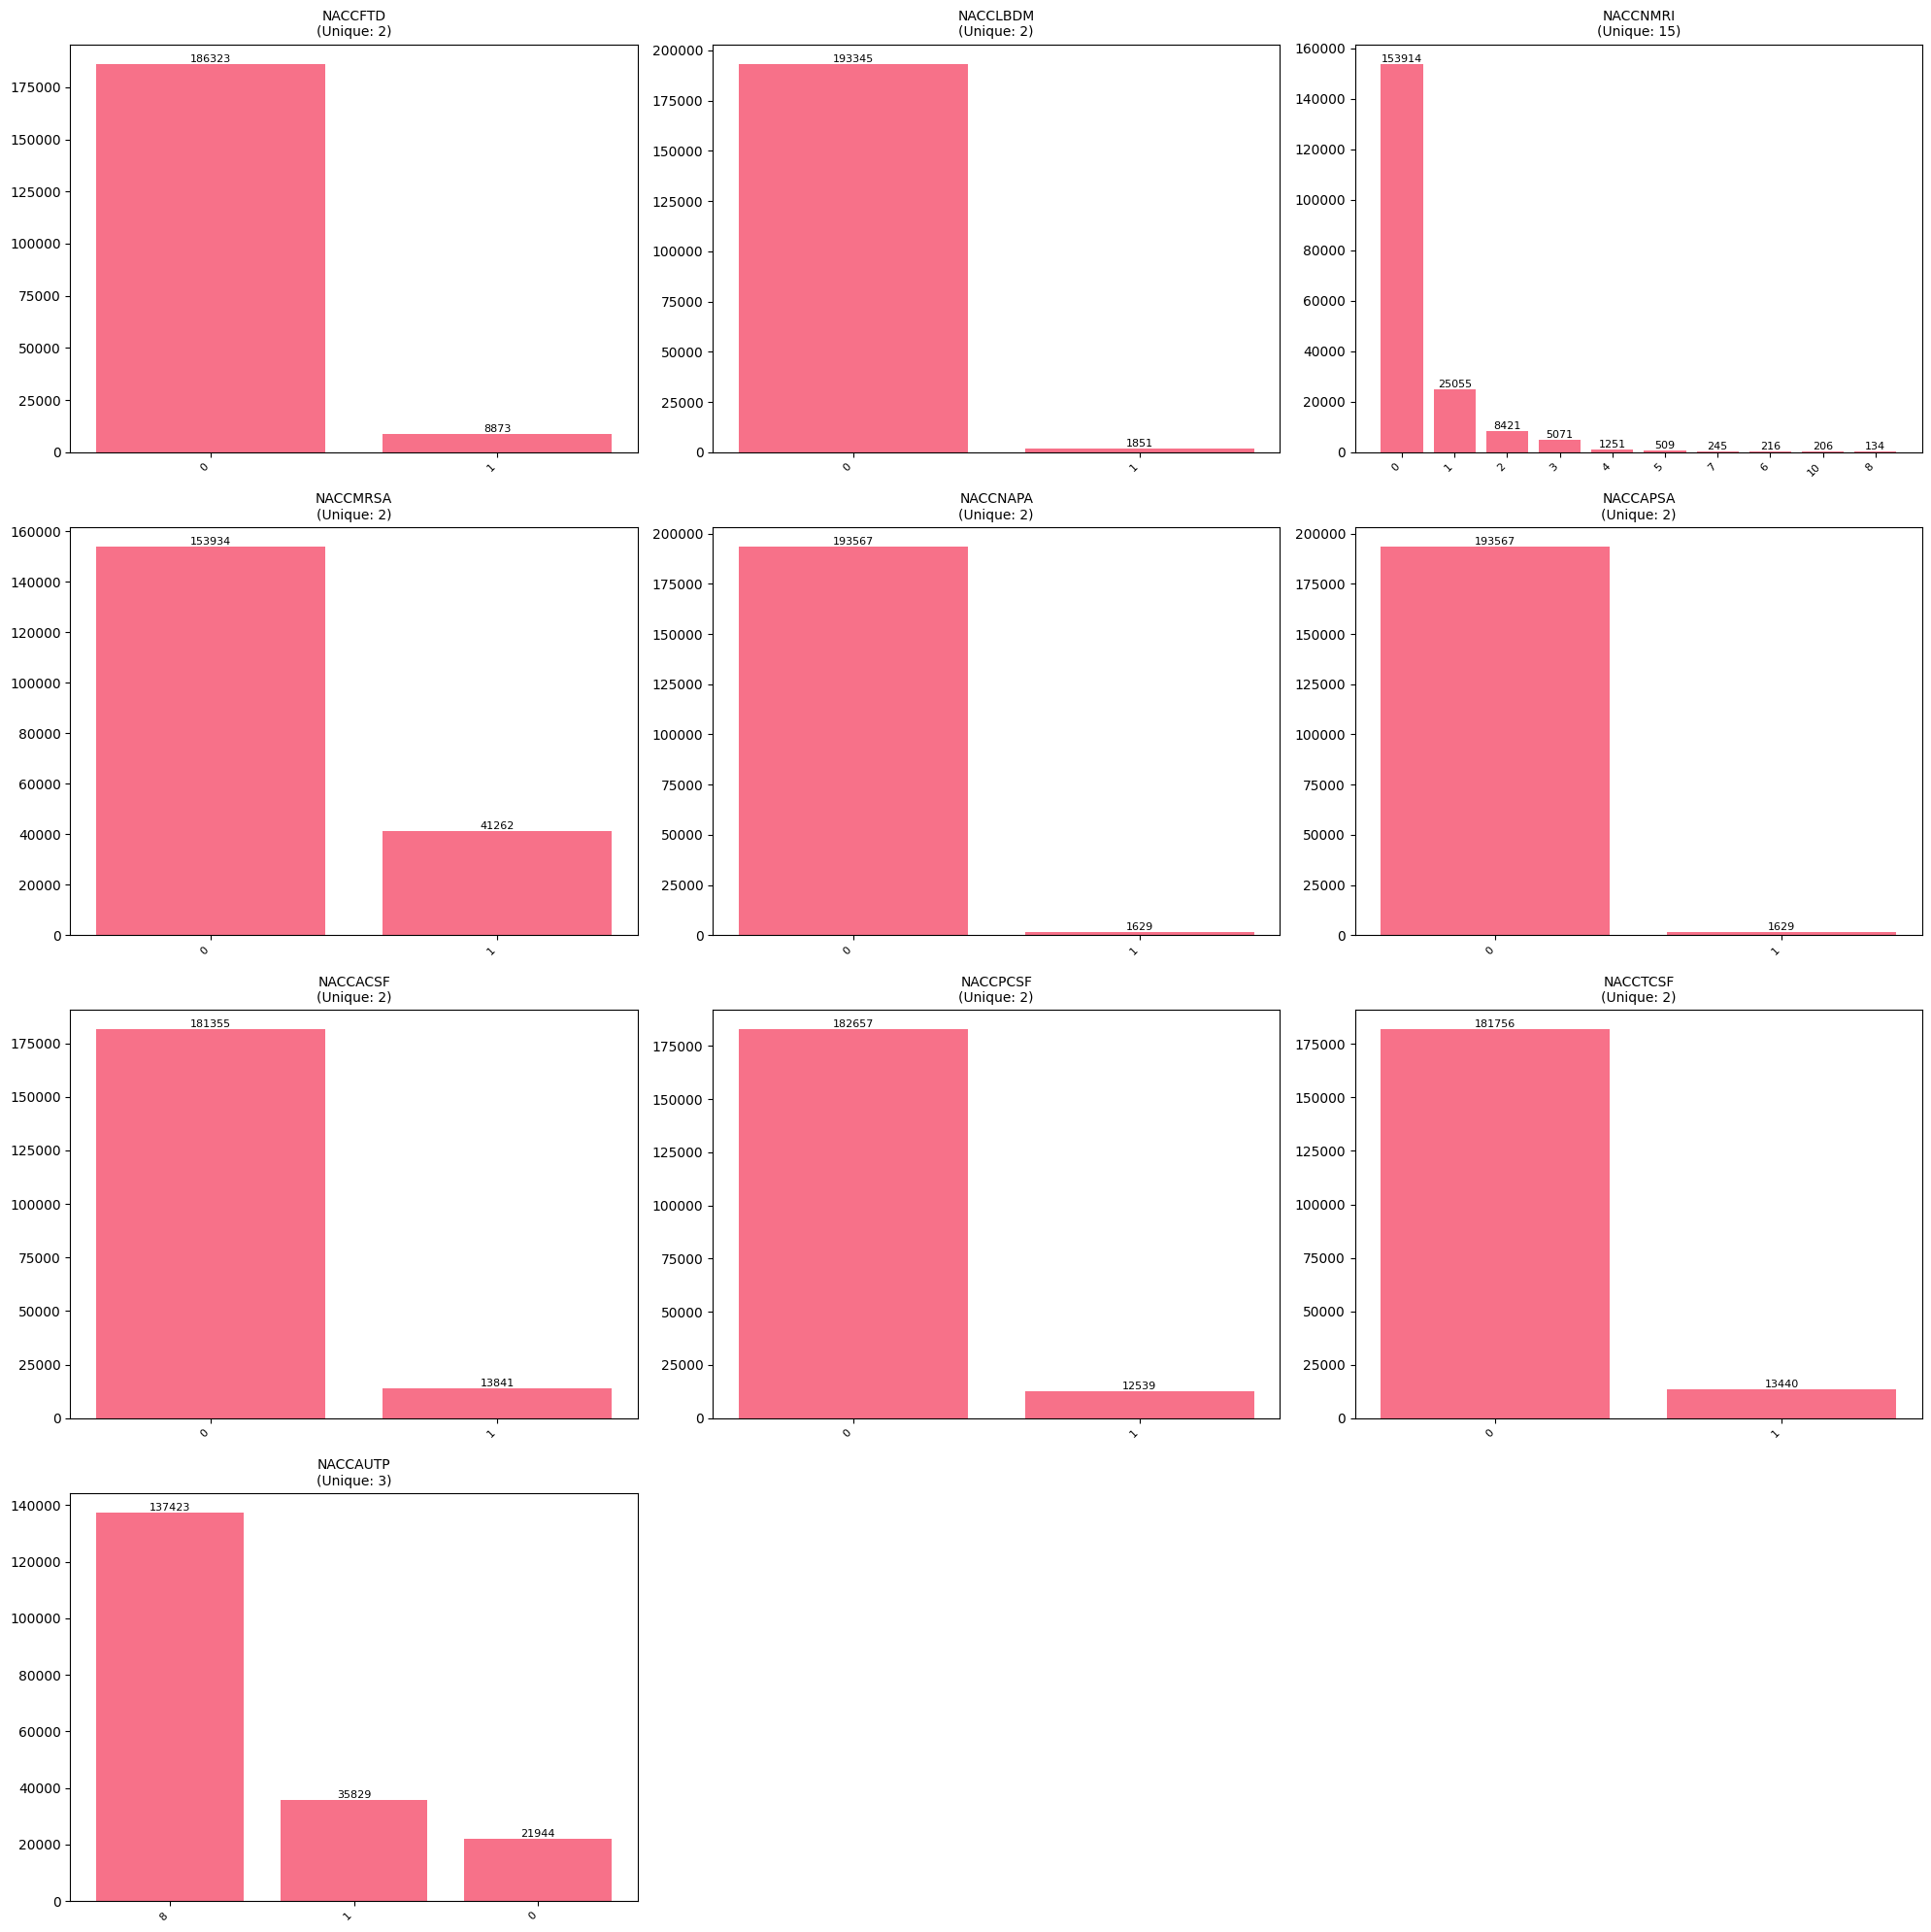


📋 DETAILED STATISTICS FOR Data Availability:
--------------------------------------------------

🔍 NACCFTD:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 2
   Top 5 values:
     0: 186323 (95.5%)
     1: 8873 (4.5%)

🔍 NACCLBDM:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 2
   Top 5 values:
     0: 193345 (99.1%)
     1: 1851 (0.9%)

🔍 NACCNMRI:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 15
   Top 5 values:
     0: 153914 (78.9%)
     1: 25055 (12.8%)
     2: 8421 (4.3%)
     3: 5071 (2.6%)
     4: 1251 (0.6%)

🔍 NACCMRSA:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 2
   Top 5 values:
     0: 153934 (78.9%)
     1: 41262 (21.1%)

🔍 NACCNAPA:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 2
   Top 5 values:
     0: 193567 (99.2%)
     1: 1629 (0.8%)

🔍 NACCAPSA:
   Data type: int64
   Missing values: 0 (0.0%)
   Unique values: 2
   Top 5 values:
     0: 193567 (99.2%)
     1: 1629 

In [12]:
# Run EDA for each category
categories = {
    'Demographics': demographic_features,
    'Administrative': administrative_features,
    'Co-participant': coparticipant_features,
    'Family History': family_history_features,
    'Language': language_features,
    'Data Availability': data_availability_features
}

for category_name, features in categories.items():
    comprehensive_eda(df, features, category_name)

🎯 ============================================================
🎯 TARGET VARIABLES ANALYSIS
🎯 ============================================================


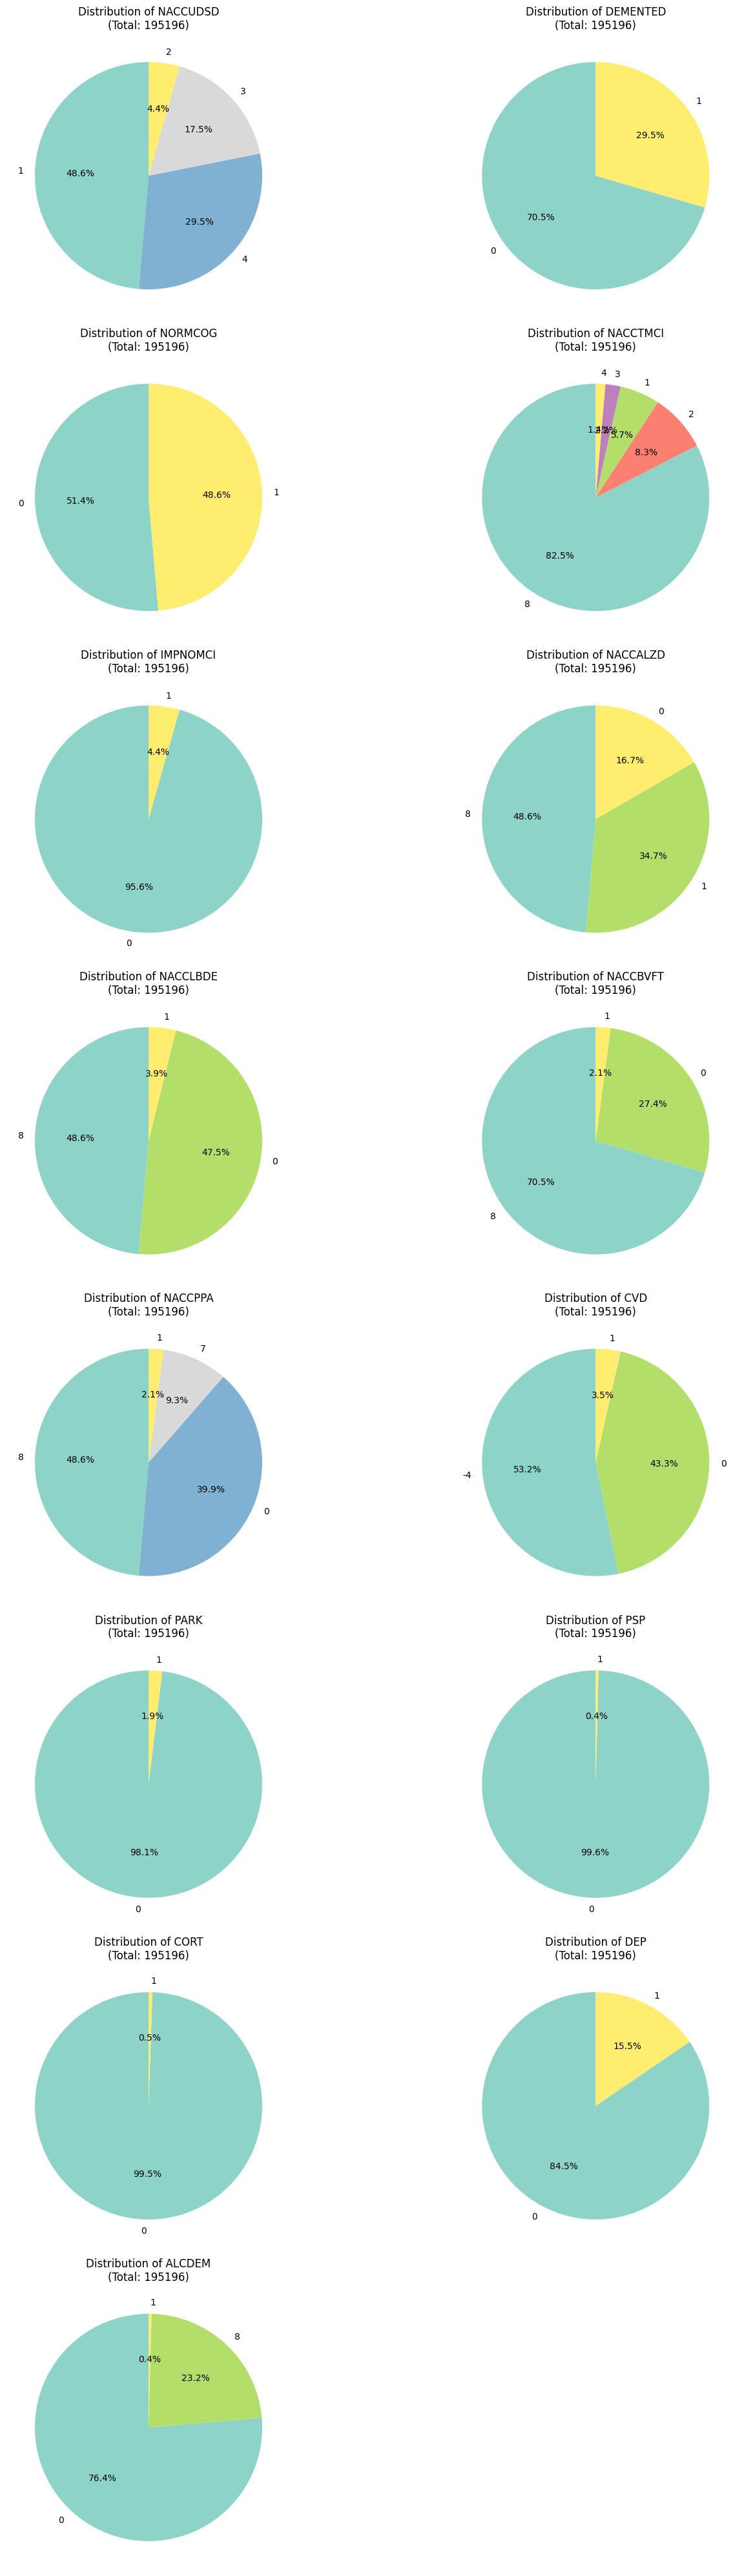


📊 TARGET VARIABLES SUMMARY:
----------------------------------------

🎯 NACCUDSD:
   Data type: int64
   Missing: 0 (0.0%)
   1: 94933 (48.6%)
   4: 57590 (29.5%)
   3: 34106 (17.5%)
   2: 8567 (4.4%)

🎯 DEMENTED:
   Data type: int64
   Missing: 0 (0.0%)
   0: 137606 (70.5%)
   1: 57590 (29.5%)

🎯 NORMCOG:
   Data type: int64
   Missing: 0 (0.0%)
   0: 100263 (51.4%)
   1: 94933 (48.6%)

🎯 NACCTMCI:
   Data type: int64
   Missing: 0 (0.0%)
   8: 161090 (82.5%)
   2: 16136 (8.3%)
   1: 11100 (5.7%)
   3: 4203 (2.2%)
   4: 2667 (1.4%)

🎯 IMPNOMCI:
   Data type: int64
   Missing: 0 (0.0%)
   0: 186629 (95.6%)
   1: 8567 (4.4%)

🎯 NACCALZD:
   Data type: int64
   Missing: 0 (0.0%)
   8: 94933 (48.6%)
   1: 67754 (34.7%)
   0: 32509 (16.7%)

🎯 NACCLBDE:
   Data type: int64
   Missing: 0 (0.0%)
   8: 94933 (48.6%)
   0: 92731 (47.5%)
   1: 7532 (3.9%)

🎯 NACCBVFT:
   Data type: int64
   Missing: 0 (0.0%)
   8: 137606 (70.5%)
   0: 53469 (27.4%)
   1: 4121 (2.1%)

🎯 NACCPPA:
   Data type: in

In [13]:
def analyze_targets(df, target_features):
    """
    Special analysis for target variables
    """
    print(f"🎯 {'='*60}")
    print(f"🎯 TARGET VARIABLES ANALYSIS")
    print(f"🎯 {'='*60}")

    available_targets = [f for f in target_features if f in df.columns]

    # Create subplots for target distributions
    n_targets = len(available_targets)
    n_cols = 2
    n_rows = (n_targets + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_targets > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, target in enumerate(available_targets):
        if i >= len(axes):
            break

        ax = axes[i]

        if df[target].dtype in ['object', 'category'] or df[target].nunique() < 10:
            # Categorical target
            value_counts = df[target].value_counts()
            colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))

            wedges, texts, autotexts = ax.pie(value_counts.values, labels=value_counts.index,
                                            autopct='%1.1f%%', colors=colors, startangle=90)
            ax.set_title(f'Distribution of {target}\n(Total: {value_counts.sum()})')

            # Improve readability
            for autotext in autotexts:
                autotext.set_color('black')
                autotext.set_fontsize(10)
        else:
            # Numerical target
            ax.hist(df[target].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            ax.set_title(f'Distribution of {target}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')

    # Hide empty subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print target statistics
    print(f"\n📊 TARGET VARIABLES SUMMARY:")
    print("-" * 40)
    for target in available_targets:
        print(f"\n🎯 {target}:")
        print(f"   Data type: {df[target].dtype}")
        print(f"   Missing: {df[target].isnull().sum()} ({df[target].isnull().mean()*100:.1f}%)")

        if df[target].dtype in ['object', 'category'] or df[target].nunique() < 10:
            value_counts = df[target].value_counts()
            for val, count in value_counts.items():
                percentage = count/len(df)*100
                print(f"   {val}: {count} ({percentage:.1f}%)")

# Run target analysis
analyze_targets(df, primary_targets + diagnosis_targets)

📈 ============================================================
📈 CORRELATION ANALYSIS
📈 ============================================================


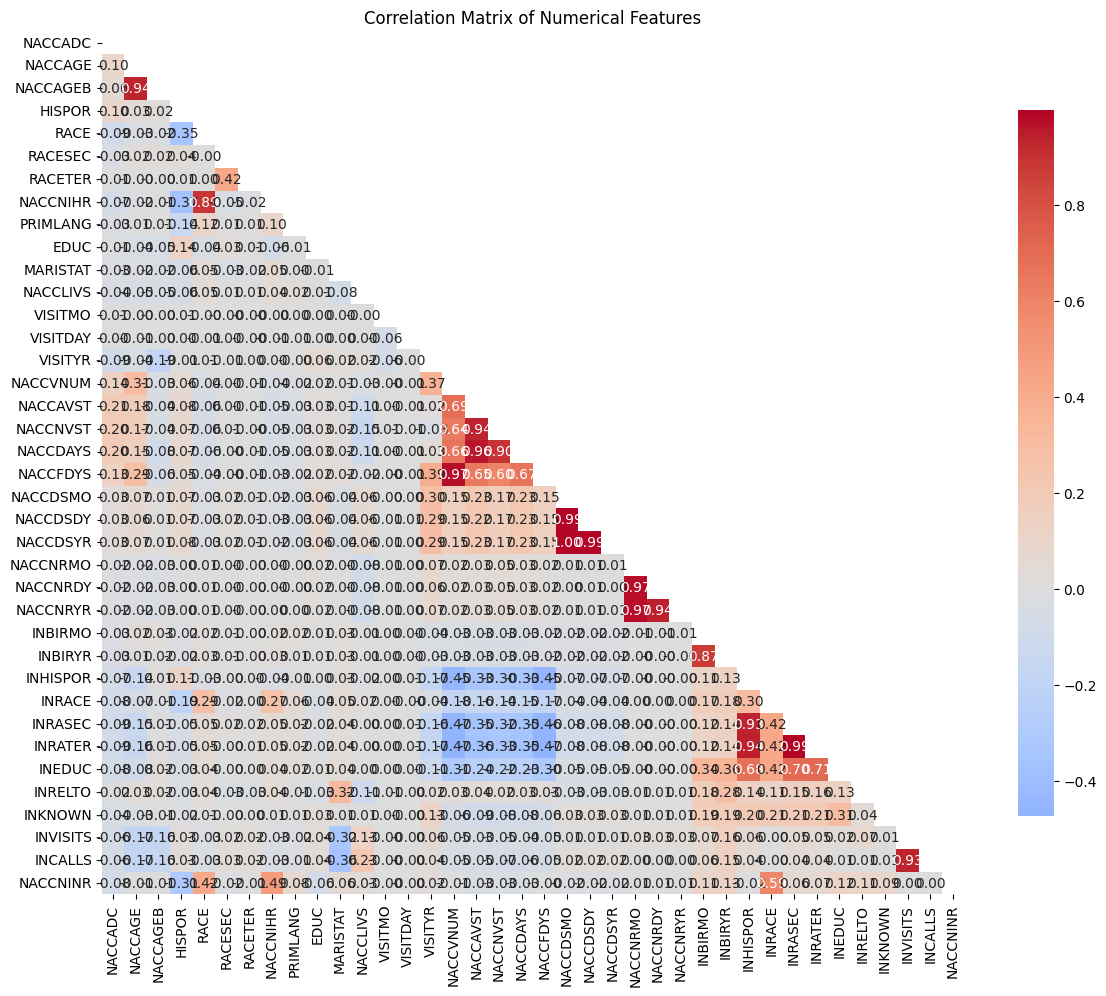


🔗 STRONG CORRELATIONS (|r| > 0.5):
   NACCDSMO ↔ NACCDSYR: 0.997
   NACCDSDY ↔ NACCDSYR: 0.987
   INRASEC ↔ INRATER: 0.987
   NACCDSMO ↔ NACCDSDY: 0.987
   NACCNRMO ↔ NACCNRYR: 0.970
   NACCNRMO ↔ NACCNRDY: 0.970
   NACCVNUM ↔ NACCFDYS: 0.969
   NACCAVST ↔ NACCDAYS: 0.962
   INHISPOR ↔ INRATER: 0.945
   NACCNRDY ↔ NACCNRYR: 0.942
   NACCAVST ↔ NACCNVST: 0.938
   NACCAGE ↔ NACCAGEB: 0.938
   INHISPOR ↔ INRASEC: 0.935
   INVISITS ↔ INCALLS: 0.934
   NACCNVST ↔ NACCDAYS: 0.898
   RACE ↔ NACCNIHR: 0.893
   INBIRMO ↔ INBIRYR: 0.873
   INRATER ↔ INEDUC: 0.710
   INRASEC ↔ INEDUC: 0.704
   NACCVNUM ↔ NACCAVST: 0.685
   INHISPOR ↔ INEDUC: 0.678
   NACCDAYS ↔ NACCFDYS: 0.668
   NACCVNUM ↔ NACCDAYS: 0.659
   NACCAVST ↔ NACCFDYS: 0.646
   NACCVNUM ↔ NACCNVST: 0.643
   NACCNVST ↔ NACCFDYS: 0.601
   INRACE ↔ NACCNINR: 0.586


In [14]:
def analyze_correlations(df, numerical_features):
    """
    Analyze correlations between numerical features
    """
    print(f"📈 {'='*60}")
    print(f"📈 CORRELATION ANALYSIS")
    print(f"📈 {'='*60}")

    # Select only numerical features that exist
    available_numerical = [f for f in numerical_features if f in df.columns and
                          df[f].dtype in ['int64', 'float64'] and df[f].nunique() > 5]

    if len(available_numerical) > 1:
        # Calculate correlation matrix
        corr_matrix = df[available_numerical].corr()

        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={"shrink": .8})
        plt.title('Correlation Matrix of Numerical Features')
        plt.tight_layout()
        plt.show()

        # Find high correlations
        print(f"\n🔗 STRONG CORRELATIONS (|r| > 0.5):")
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) > 0.5:
                    high_corr_pairs.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_matrix.iloc[i, j]
                    ))

        if high_corr_pairs:
            for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
                print(f"   {feat1} ↔ {feat2}: {corr:.3f}")
        else:
            print("   No strong correlations found")
    else:
        print("Not enough numerical features for correlation analysis")

# Get all numerical features from our categories
all_features = demographic_features + administrative_features + coparticipant_features + family_history_features
analyze_correlations(df, all_features)

🎯 ============================================================
🎯 RELATIONSHIP WITH TARGET: NACCUDSD
🎯 ============================================================


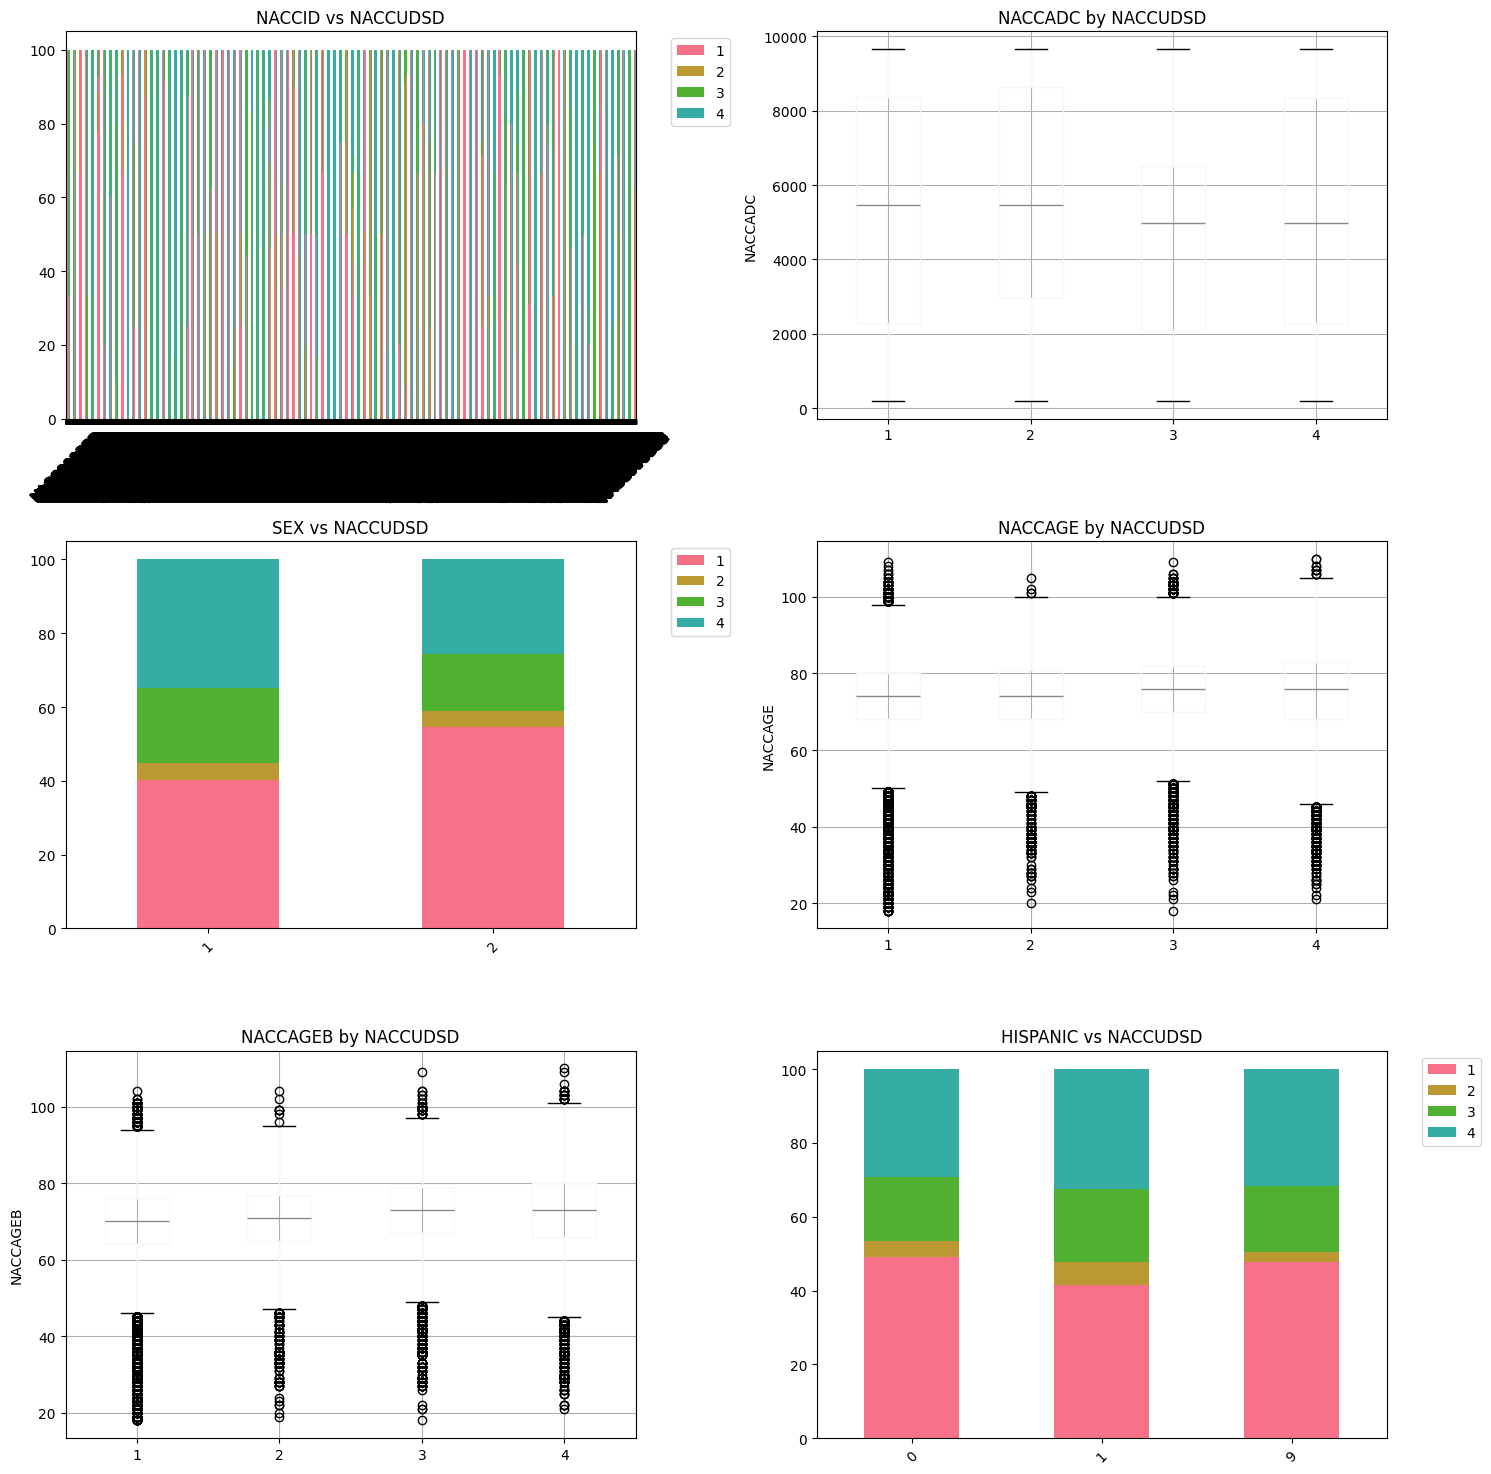

In [15]:
def analyze_target_relationships(df, features, target_var='NACCUDSD'):
    """
    Analyze relationships between features and main target
    """
    if target_var not in df.columns:
        print(f"Target variable {target_var} not found in dataset")
        return

    print(f"🎯 {'='*60}")
    print(f"🎯 RELATIONSHIP WITH TARGET: {target_var}")
    print(f"🎯 {'='*60}")

    available_features = [f for f in features if f in df.columns and f != target_var]

    # Select top 6 features for visualization
    top_features = available_features[:6]

    if len(top_features) > 0:
        n_cols = 2
        n_rows = (len(top_features) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if len(top_features) > 1 else [axes]

        for i, feature in enumerate(top_features):
            if i >= len(axes):
                break

            ax = axes[i]

            if df[feature].dtype in ['object', 'category'] or df[feature].nunique() < 10:
                # Categorical feature vs categorical target
                cross_tab = pd.crosstab(df[feature], df[target_var], normalize='index') * 100
                cross_tab.plot(kind='bar', ax=ax, stacked=True)
                ax.set_title(f'{feature} vs {target_var}')
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                ax.tick_params(axis='x', rotation=45)
            else:
                # Numerical feature vs categorical target
                df_clean = df[[feature, target_var]].dropna()
                if len(df_clean) > 0:
                    df_clean.boxplot(column=feature, by=target_var, ax=ax)
                    ax.set_title(f'{feature} by {target_var}')
                    ax.set_ylabel(feature)

            ax.set_xlabel('')

        # Hide empty subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('')  # Remove automatic title
        plt.tight_layout()
        plt.show()

# Analyze relationships with primary target
analyze_target_relationships(df, demographic_features + administrative_features)

In [16]:
def plot_feature_vs_target(df, feature, target_var):
    """
    Plot single feature vs target variable
    """
    # Filter out missing values
    plot_data = df[[feature, target_var]].dropna()

    fig = px.box(
        plot_data,
        x=target_var,
        y=feature,
        color=target_var,
        points='all',
        title=f"Boxplot of {feature} by {target_var}",
        height=500
    )

    fig.update_layout(
        xaxis_title=target_var,
        yaxis_title=feature,
        showlegend=False
    )

    fig.show()

    # statistics
    print(f"Statistics for {feature} by {target_var}:")
    stats = plot_data.groupby(target_var)[feature].describe()
    print(stats)

plot_feature_vs_target(df, 'NACCAGE', 'NACCUDSD')
plot_feature_vs_target(df, 'EDUC', 'DEMENTED')

Statistics for NACCAGE by NACCUDSD:
            count       mean        std   min   25%   50%   75%    max
NACCUDSD                                                              
1         94933.0  73.533218  10.324627  18.0  68.0  74.0  80.0  109.0
2          8567.0  73.770748  10.092138  20.0  68.0  74.0  81.0  105.0
3         34106.0  75.564270   9.630998  18.0  70.0  76.0  82.0  109.0
4         57590.0  75.128234  10.553226  21.0  68.0  76.0  83.0  110.0


Statistics for EDUC by DEMENTED:
             count       mean       std  min   25%   50%   75%   max
DEMENTED                                                            
0         137606.0  16.169171  6.015326  0.0  14.0  16.0  18.0  99.0
1          57590.0  15.511599  8.088520  0.0  12.0  16.0  18.0  99.0


In [17]:
# ONLY non-medical temporal features
non_medical_temporal = [
    'VISITMO', 'VISITDAY', 'VISITYR',        # Form date
    'BIRTHMO', 'BIRTHYR',                    # Subject birth date
    'INBIRMO', 'INBIRYR',                    # Co-participant birth date
    'NACCDAYS', 'NACCFDYS',                  # Days from initial visit
    'NACCMOD', 'NACCYOD',                    # Month/Year of death
    'NACCDSMO', 'NACCDSDY', 'NACCDSYR',      # Discontinuation date
    'NACCNRMO', 'NACCNRDY', 'NACCNRYR',      # Nursing home move date
    'visit_date', 'birth_date', 'age_exact'  # Created datetime features
]

# Create datetime features (NON-MEDICAL only)
def create_non_medical_datetime(df):
    """Create proper datetime features from NON-MEDICAL components"""

    # Create visit date from non-medical components
    df['visit_date'] = pd.to_datetime(
        df['VISITYR'].astype(str) + '-' +
        df['VISITMO'].astype(str) + '-' +
        df['VISITDAY'].fillna(15).astype(int).astype(str),
        errors='coerce'
    )

    # Create birth date from non-medical components
    df['birth_date'] = pd.to_datetime(
        df['BIRTHYR'].astype(str) + '-' +
        df['BIRTHMO'].astype(str) + '-15',
        errors='coerce'
    )

    # Calculate exact age at visit (non-medical)
    df['age_exact'] = (df['visit_date'] - df['birth_date']).dt.days / 365.25

    return df

# Apply NON-MEDICAL datetime creation
df = create_non_medical_datetime(df)

In [18]:
def plot_non_medical_temporal(df, value_col, time_col='visit_date', group_col=None):
    """
    Plot NON-MEDICAL temporal trends over time
    """
    # Validate columns exist and are non-medical
    valid_cols = [col for col in [time_col, value_col, group_col] if col is not None]
    for col in valid_cols:
        if col not in df.columns:
            print(f"❌ Column {col} not found")
            return

    plot_data = df[[time_col, value_col, group_col]].dropna() if group_col else df[[time_col, value_col]].dropna()

    if len(plot_data) == 0:
        print("❌ No data available")
        return

    if group_col:
        fig = px.line(
            plot_data,
            x=time_col,
            y=value_col,
            color=group_col,
            title=f"NON-MEDICAL: {value_col} by {group_col} Over Time",
            height=500
        )
    else:
        if plot_data[time_col].dtype == 'datetime64[ns]':
            # Resample by month for time series
            time_series = plot_data.set_index(time_col)[value_col].resample('M').mean().reset_index()
            fig = px.line(
                time_series,
                x=time_col,
                y=value_col,
                title=f"NON-MEDICAL: {value_col} Over Time (Monthly Average)",
                height=500
            )
        else:
            fig = px.line(
                plot_data,
                x=time_col,
                y=value_col,
                title=f"NON-MEDICAL: {value_col} by {time_col}",
                height=500
            )

    fig.show()

# Examples of NON-MEDICAL temporal plots
plot_non_medical_temporal(df, 'NACCAGE', 'visit_date')
plot_non_medical_temporal(df, 'EDUC', 'visit_date', 'SEX')
plot_non_medical_temporal(df, 'NACCDAYS', 'visit_date')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ONLY non-medical spatial features
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ModelX/Dementia Prediction Dataset.csv')
non_medical_spatial = [
    'NACCADC',           # Alzheimer's Disease Center ID (geographic location)
    'RESIDENC',          # Type of residence
    'NACCLIVS',          # Living situation
    'center_lat',        # Created spatial coordinates
    'center_lon',        # Created spatial coordinates
    'center_name'        # Created center names
]

def create_non_medical_center_map(df, value_col='NACCID'):
    """
    Create NON-MEDICAL map visualizations by center location
    """
    if 'center_lat' not in df.columns or 'center_lon' not in df.columns:
        print("❌ Spatial coordinates not available")
        return

    # Aggregate NON-MEDICAL data by center
    center_stats = df.groupby(['center_name', 'center_lat', 'center_lon']).agg({
        'NACCID': 'count',
        'NACCAGE': 'mean',
        'EDUC': 'mean',
        'SEX': lambda x: (x == 2).mean()  # Percentage female
    }).reset_index()

    center_stats = center_stats.rename(columns={
        'NACCID': 'subject_count',
        'SEX': 'percent_female'
    })

    center_stats = center_stats.dropna(subset=['center_lat', 'center_lon'])

    fig = px.scatter_mapbox(
        center_stats,
        lat="center_lat",
        lon="center_lon",
        size="subject_count",
        color="NACCAGE",  # Non-medical: average age
        hover_name="center_name",
        hover_data=["subject_count", "NACCAGE", "EDUC", "percent_female"],
        color_continuous_scale=px.colors.sequential.Viridis,
        size_max=30,
        zoom=3,
        title="NON-MEDICAL: Research Centers - Age Distribution & Subject Count"
    )

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
    fig.show()

    return center_stats

def create_demographic_by_center_map(df, demographic_col='EDUC'):
    """
    Create map showing NON-MEDICAL demographic distribution by center
    """
    if demographic_col not in df.columns:
        print(f"❌ Demographic column {demographic_col} not found")
        return

    # Calculate demographic stats by center
    demo_by_center = df.groupby(['center_name', 'center_lat', 'center_lon']).agg({
        demographic_col: 'mean',
        'NACCID': 'count'
    }).reset_index()

    demo_by_center = demo_by_center.rename(columns={
        'NACCID': 'total_subjects',
        demographic_col: f'avg_{demographic_col}'
    })

    demo_by_center = demo_by_center.dropna(subset=['center_lat', 'center_lon'])

    fig = px.scatter_mapbox(
        demo_by_center,
        lat="center_lat",
        lon="center_lon",
        size="total_subjects",
        color=f"avg_{demographic_col}",
        hover_name="center_name",
        hover_data=["total_subjects", f"avg_{demographic_col}"],
        color_continuous_scale="Viridis",
        size_max=30,
        zoom=3,
        title=f"NON-MEDICAL: {demographic_col} Distribution by Research Center"
    )

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
    fig.show()

# Example NON-MEDICAL map visualizations
if 'center_lat' in df.columns and df['center_lat'].notna().any():
    create_non_medical_center_map(df)
    create_demographic_by_center_map(df, 'EDUC')
    create_demographic_by_center_map(df, 'NACCAGE')
else:
    print("ℹ️ No spatial coordinates available for map visualizations")

/tmp/ipython-input-630855807.py:2: DtypeWarning:

Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
def non_medical_spatiotemporal(df):
    """
    Combine NON-MEDICAL spatial and temporal analysis
    """
    # Growth of subjects by center over time (non-medical)
    growth_by_center = df.groupby([df['visit_date'].dt.year, 'NACCADC']).size().reset_index()
    growth_by_center = growth_by_center.rename(columns={0: 'visit_count'})

    # Create heatmap
    pivot_data = growth_by_center.pivot(index='NACCADC', columns='visit_date', values='visit_count').fillna(0)

    fig = px.imshow(
        pivot_data,
        aspect="auto",
        title='NON-MEDICAL: Visit Activity by Center Over Time',
        color_continuous_scale='Blues',
        labels=dict(x="Year", y="Research Center", color="Visit Count")
    )
    fig.show()

    # Demographic changes over time by center
    if 'NACCAGE' in df.columns:
        age_by_center_time = df.groupby([df['visit_date'].dt.year, 'NACCADC'])['NACCAGE'].mean().reset_index()

        fig = px.line(
            age_by_center_time,
            x='visit_date',
            y='NACCAGE',
            color='NACCADC',
            title='NON-MEDICAL: Average Age by Research Center Over Time',
            markers=True
        )
        fig.show()

non_medical_spatiotemporal(df)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ModelX/Dementia Prediction Dataset.csv')
def plot_non_medical_scatter(df, x_col, y_col, color_col=None, size_col=None, title=None):
    """Create scatter plots for NON-MEDICAL features only"""

    # Check if columns exist
    missing_cols = [col for col in [x_col, y_col, color_col, size_col]
                   if col is not None and col not in df.columns]
    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        return

    # Filter out medical features (double-check)
    non_medical_safe = all(col in demographic_features + administrative_features +
                          coparticipant_features + family_history_features +
                          language_features for col in [x_col, y_col]
                          if col is not None)

    if not non_medical_safe:
        print("⚠️  Warning: Potential medical features detected")
        return

    plot_data = df[[x_col, y_col, color_col, size_col]].copy().dropna()

    if len(plot_data) == 0:
        print("❌ No data available after removing missing values")
        return

    if title is None:
        title = f"NON-MEDICAL: {y_col} vs {x_col}"
        if color_col:
            title += f" by {color_col}"

    fig = px.scatter(
        plot_data,
        x=x_col,
        y=y_col,
        color=color_col,
        size=size_col,
        title=title,
        height=500,
        opacity=0.7,
        hover_data=plot_data.columns.tolist()
    )

    # Add trendline for numerical vs numerical
    if (plot_data[x_col].dtype in ['int64', 'float64'] and
        plot_data[y_col].dtype in ['int64', 'float64']):
        fig.update_traces(
            marker=dict(size=8, line=dict(width=1, color='DarkSlateGrey'))
        )

    fig.show()

    # Print correlation if both numerical
    if (plot_data[x_col].dtype in ['int64', 'float64'] and
        plot_data[y_col].dtype in ['int64', 'float64']):
        correlation = plot_data[x_col].corr(plot_data[y_col])
        print(f"📊 Correlation between {x_col} and {y_col}: {correlation:.3f}")

# Basic demographic scatter plots
plot_non_medical_scatter(df, 'NACCAGE', 'EDUC', color_col='SEX',
                        title='NON-MEDICAL: Education vs Age by Gender')